This notebook shows the TensorFlow Lite model conversion and inference processes for the **Image Scene Classification** model. This model is capable of classifying image scene like:

![](https://i.imgur.com/79DXWt0.jpeg)



## Imports

In [16]:
import os
import numpy as np
from tqdm import tqdm
from imutils import paths
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.7.0


## Data gathering

In [2]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Download the pre-trained weights

In [7]:
!wget -q https://firebasestorage.googleapis.com/v0/b/signal-detector-9d349.appspot.com/o/image_scene_model.tar?alt=media&token=ae03faed-fcde-4974-bdcc-3ce3e06d53a3
!tar -xvf "image_scene_model.tar"

image_scene_model/
image_scene_model/keras_metadata.pb
image_scene_model/saved_model.pb
image_scene_model/assets/
image_scene_model/variables/
image_scene_model/variables/variables.index
image_scene_model/variables/variables.data-00000-of-00001


In [10]:
SAVED_MODEL_FILE = 'image_scene_model/'
TFLITE_MODEL_FILE = 'image_scene.tflite'

## Conversion of model into TF-Lite

In [11]:
# Load the save model
model = keras.models.load_model(SAVED_MODEL_FILE)

# Convert the save model into tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS 
]

tflite_model = converter.convert()
open(TFLITE_MODEL_FILE, 'wb').write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

INFO:tensorflow:Assets written to: /tmp/tmp8feoa6qe/assets


Model size is 7.944885 MBs.


## Check tensor-shape

In [12]:
interpreter = tf.lite.Interpreter(model_path = TFLITE_MODEL_FILE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 30]
Output Type: <class 'numpy.float32'>


## Data parsing

In [13]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
print(image_paths[:5])

['training/6_Macro/204.jpg', 'training/19_Autumn_leaves/238.jpg', 'training/28_Text_Documents/291.jpg', 'training/12_Landscape/177.jpg', 'training/2_Group_portrait/48.jpg']


In [14]:
labels = []
for image_path in tqdm(image_paths):
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count) 

100%|██████████| 9897/9897 [00:00<00:00, 951978.60it/s]

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [15]:
TRAIN_SPLIT = 0.95

i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
test_paths = image_paths[i:]
test_labels = labels[i:]

print(len(train_paths), len(test_paths))

9402 495


In [17]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(test_labels)
print(train_labels_le[:5])

[26  9 19  2 21]


## Dataloader utilities

In [18]:
IMG_SIZE = 224
BATCH_SIZE = 16

In [19]:
@tf.function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

In [22]:
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

In [23]:
test_imgs, test_labels = next(iter(test_ds))
print(test_imgs.shape)

(16, 224, 224, 3)


## Reshape tensor shape

In [24]:
interpreter.resize_tensor_input(input_details[0]['index'], (16, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (16, 30))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 16 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [16 30]
Output Type: <class 'numpy.float32'>


## Inference on TensorFlow-Lite

In [25]:
interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes_le = np.argmax(tflite_model_predictions, axis=1)
prediction_classes = le.inverse_transform(prediction_classes_le)

Prediction results shape: (16, 30)


## Results

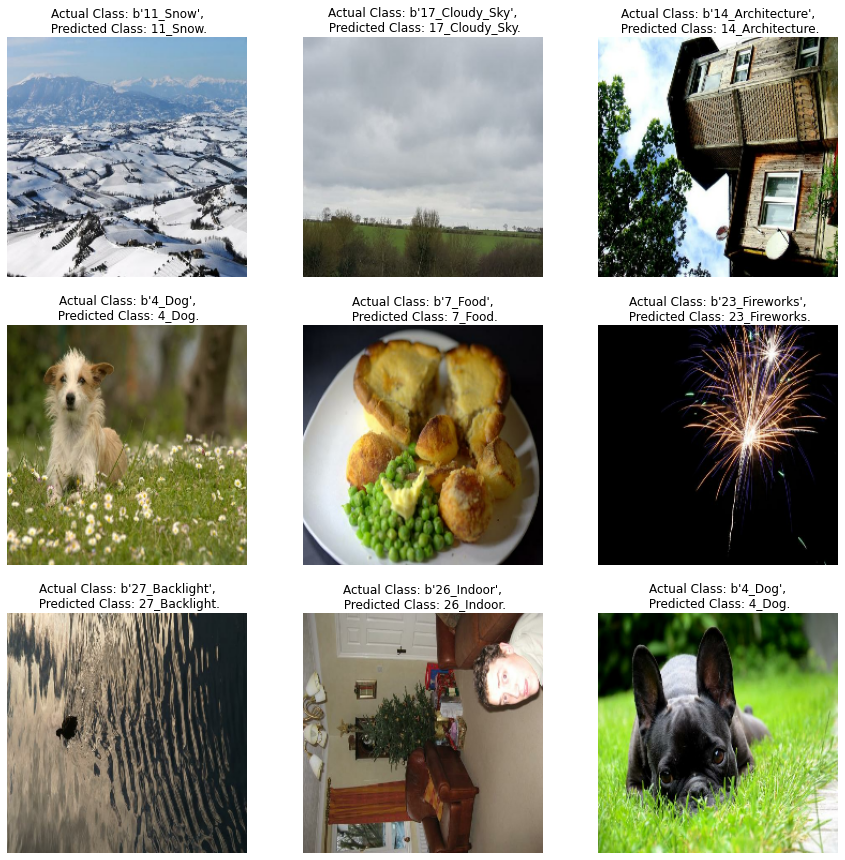

In [26]:
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_imgs[i].numpy().astype("uint8"))
    plt.title(f"Actual Class: {test_labels[i]},\n Predicted Class: {prediction_classes[i]}.")
    plt.axis("off")